In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, re, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai.data.lenses_tng_v3 import decode_train, decode_physical_model_info
from censai import PhysicalModelv2, RIMSharedUnetv3
from censai.models import SharedUnetModelv4
from argparse import Namespace
from censai.definitions import logit
import math, json
import matplotlib.pylab as pylab
import tensorflow as tf
import h5py
from astropy.visualization import ImageNormalize, LogStretch
from tqdm import tqdm
import tensorflow_probability as tfp

DTYPE = tf.float32


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 200)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 30,#'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
# plt.style.use("science")

2021-12-09 20:07:23.363248: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-09 20:07:26.000989: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-09 20:07:26.002339: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-09 20:07:26.268469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-12-09 20:07:26.268493: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-09 20:07:26.295164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

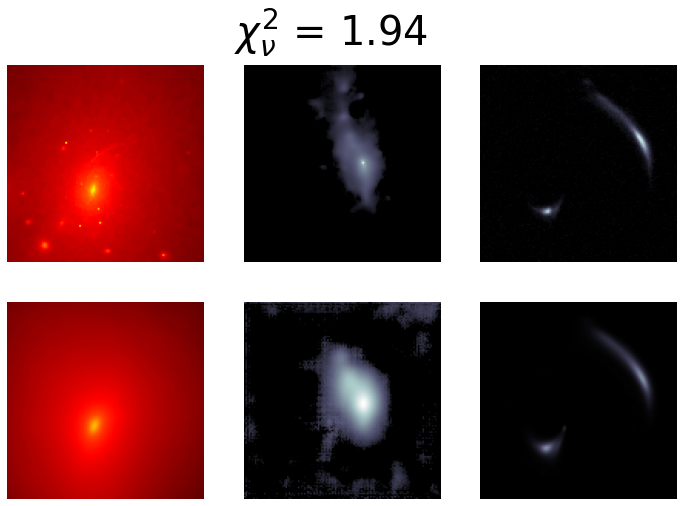

In [2]:
# model = "RIMSU128hstv4_augmented_009_RMSP0_TS8_F16_NLleaky_relu_TWuniform_KRWsqrt_211117182256"
model = "RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839"
hf = h5py.File(os.getenv('CENSAI_PATH') + "results/RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839_RIMSource128hstv3_control_001_A0_L2_FLM0.0_211108220845.h5", 'r')
k = 0
# dataset = "lenses128hst_TNG_rau_200k_control_denoised_validated_train"
dataset = 'lenses128hst_TNG_rau_200k_control_denoised_testset_validated'

lens = np.array(hf[dataset][f"lens"]).squeeze()[k][None, ..., None]
source = np.array(hf[dataset][f"source"]).squeeze()[k][None, ..., None]
kappa = np.array(hf[dataset][f"kappa"]).squeeze()[k][None, ..., None]
lens_pred = np.array(hf[dataset][f"lens_pred"]).squeeze()[k][None, ..., None]
source_pred = np.array(hf[dataset][f"source_pred"]).squeeze()[k][-1][None, ..., None]
kappa_pred = np.array(hf[dataset][f"kappa_pred"]).squeeze()[k][-1][None, ..., None]
chi_squared = 2*np.array(hf[dataset][f"chi_squared"]).squeeze()[k]
noise_rms = np.array(hf[dataset]["noise_rms"])[k]
psf = np.array(hf[dataset]["psf"]).squeeze()[k][None, ..., None]


hf.close();

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0, 0].imshow(kappa[0, ..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
axs[0, 1].imshow(logit(source[0, ..., 0]), cmap="bone")#, vmin=0, vmax=1)
axs[0, 2].imshow(lens[0, ..., 0], cmap= "bone", vmin=0, vmax=1)
axs[1, 0].imshow(kappa_pred[0, ..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
axs[1, 1].imshow(logit(source_pred[0, ..., 0]), cmap="bone")#, vmin=0, vmax=1)
axs[1, 2].imshow(lens_pred[0, ..., 0], cmap= "bone", vmin=0, vmax=1)
for i in range(2):
    for j in range(3):
        axs[i, j].axis("off")
fig.suptitle(fr"$\chi^2_\nu$ = {chi_squared[-1]:.2f}", fontsize=40)
noise_rms = np.array([noise_rms])

In [3]:

files = []
for _dataset in [os.path.join(os.getenv('CENSAI_PATH'), "data", dataset)][:1]:
    files.extend(glob.glob(os.path.join(_dataset, "*.tfrecords")))
np.random.shuffle(files)
# Read concurrently from multiple records
files = tf.data.Dataset.from_tensor_slices(files)
_dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"),
                           block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
# Read off global parameters from first example in dataset
for physical_params in _dataset.map(decode_physical_model_info):
    break

phys = PhysicalModelv2(
    pixels=physical_params["pixels"].numpy(),
    kappa_pixels=physical_params["kappa pixels"].numpy(),
    src_pixels=physical_params["src pixels"].numpy(),
    image_fov=physical_params["image fov"].numpy(),
    kappa_fov=physical_params["kappa fov"].numpy(),
    src_fov=physical_params["source fov"].numpy(),
    method="fft",
)



2021-12-09 20:07:30.032838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-09 20:07:30.045100: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2645120000 Hz


In [4]:
checkpoints_dir = os.path.join(os.getenv('CENSAI_PATH'), "models", model)
with open(os.path.join(checkpoints_dir, "script_params.json"), "r") as f:
    args = json.load(f)
args = Namespace(**args)
unet = SharedUnetModelv4(
    filters=args.filters,
    filter_scaling=args.filter_scaling,
    kernel_size=args.kernel_size,
    layers=args.layers,
    block_conv_layers=args.block_conv_layers,
    strides=args.strides,
    bottleneck_kernel_size=args.bottleneck_kernel_size,
    resampling_kernel_size=args.resampling_kernel_size,
    input_kernel_size=args.input_kernel_size,
    gru_kernel_size=args.gru_kernel_size,
    upsampling_interpolation=args.upsampling_interpolation,
#     kernel_l2_amp=args.kernel_l2_amp,
#     bias_l2_amp=args.bias_l2_amp,
#     kernel_l1_amp=args.kernel_l1_amp,
#     bias_l1_amp=args.bias_l1_amp,
    kernel_l2_amp=1e-2,
    bias_l2_amp=1e-2,
    activation=args.activation,
    initializer=args.initializer,
    batch_norm=args.batch_norm,
    dropout_rate=args.dropout_rate,
    filter_cap=args.filter_cap
)
rim = RIMSharedUnetv3(
    physical_model=phys,
    unet=unet,
    steps=args.steps,
    adam=args.adam,
    kappalog=args.kappalog,
    source_link=args.source_link,
    kappa_normalize=args.kappa_normalize,
    flux_lagrange_multiplier=args.flux_lagrange_multiplier
)
ckpt = tf.train.Checkpoint(net=rim.unet)
checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

# Transfer learning

In [5]:
source_o, kappa_o, chi_sq = rim.predict(lens, noise_rms, psf)
lens_pred = phys.forward(source_o[-1], kappa_o[-1], psf)

2021-12-09 20:07:30.322313: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-12-09 20:07:31.687886: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-09 20:07:31.725583: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-09 20:07:32.509566: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-09 20:07:32.855915: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-12-09 20:07:48.394072: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
20

In [6]:
2*chi_sq

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[9.418036 ],
       [3.8928554],
       [2.30332  ],
       [2.1889522],
       [2.004695 ],
       [2.0090418],
       [1.8453166],
       [1.9549237]], dtype=float32)>

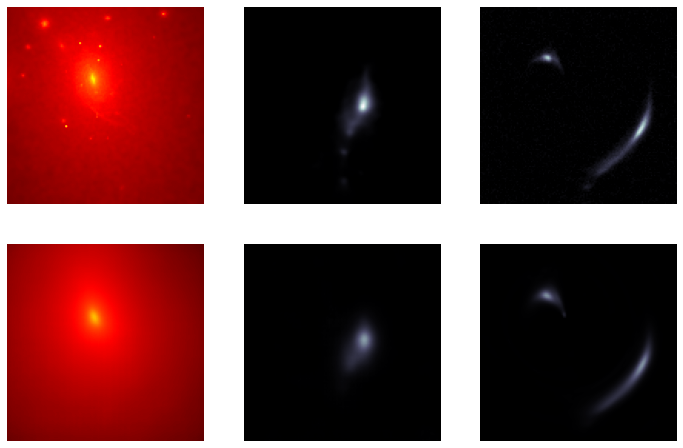

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0, 0].imshow(kappa[0, ..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100), origin="lower")
axs[0, 1].imshow(source[0, ..., 0], cmap="bone", vmin=0, vmax=1, origin="lower")
axs[0, 2].imshow(lens[0, ..., 0], cmap= "bone", vmin=0, vmax=1, origin="lower")
axs[1, 0].imshow(kappa_o[-1, 0, ..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100), origin="lower")
axs[1, 1].imshow(source_o[-1, 0, ..., 0], cmap="bone", vmin=0, vmax=1, origin="lower")
axs[1, 2].imshow(lens_pred[0, ..., 0], cmap= "bone", vmin=0, vmax=1, origin="lower")
for i in range(2):
    for j in range(3):
        axs[i, j].axis("off")

In [8]:
from censai.utils import nulltape
def call_with_mask(self, lensed_image, noise_rms, psf, mask, outer_tape=nulltape):
    """
    Used in training. Return linked kappa and source maps.
    """
    batch_size = lensed_image.shape[0]
    source, kappa, source_grad, kappa_grad, states = self.initial_states(batch_size)  # initiate all tensors to 0
    source, kappa, states = self.time_step(lensed_image, source, kappa, source_grad, kappa_grad, states)  # Use lens to make an initial guess with Unet
    source_series = tf.TensorArray(DTYPE, size=self.steps)
    kappa_series = tf.TensorArray(DTYPE, size=self.steps)
    chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
    # record initial guess
    source_series = source_series.write(index=0, value=source)
    kappa_series = kappa_series.write(index=0, value=kappa)
    # Main optimization loop
    for current_step in tf.range(self.steps-1):
        with outer_tape.stop_recording():
            with tf.GradientTape() as g:
                g.watch(source)
                g.watch(kappa)
                y_pred = self.physical_model.forward(self.source_link(source), self.kappa_link(kappa), psf)
                flux_term = tf.square(tf.reduce_sum(y_pred, axis=(1, 2, 3)) - tf.reduce_sum(lensed_image, axis=(1, 2, 3)))
                log_likelihood = 0.5 * tf.reduce_sum(mask * tf.square(y_pred - lensed_image) / noise_rms[:, None, None, None]**2, axis=(1, 2, 3))
                cost = tf.reduce_mean(log_likelihood + self.flux_lagrange_multiplier * flux_term)
            source_grad, kappa_grad = g.gradient(cost, [source, kappa])
            source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
        source, kappa, states = self.time_step(lensed_image, source, kappa, source_grad, kappa_grad, states)
        source_series = source_series.write(index=current_step+1, value=source)
        kappa_series = kappa_series.write(index=current_step+1, value=kappa)
        chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood/self.pixels**2)  # renormalize chi squared here
    # last step score
    log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=self.kappa_link(kappa), psf=psf, noise_rms=noise_rms)
    chi_squared_series = chi_squared_series.write(index=self.steps-1, value=log_likelihood)
    return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()
# x = np.linspace(-1, 1, 128) * 64
# xx, yy = np.meshgrid(x, x)
# r = np.sqrt(xx**2 + yy**2)[None, ..., None]
mask = tf.cast(lens > 0.01, DTYPE)
# plt.imshow(mask[0, ..., 0])

In [9]:
tf.reduce_sum(rim.unet.losses)

<tf.Tensor: shape=(), dtype=float32, numpy=381.5956>

In [10]:
rim.unet.layers

In [11]:
# Freeze layers 1 and 2
rim.unet.layers[0].trainable = False
rim.unet.layers[1].trainable = False
# rim.unet.layers[2].trainable = False
rim.unet.layers[-1].trainable = False
rim.unet.layers[-2].trainable = False
rim.unet.layers[5].trainable = False
rim.unet.layers[6].trainable = False
# rim.unet.layers[12].trainable = False
rim.unet.layers[13].trainable = False
rim.unet.layers[14].trainable = False

In [12]:
STEPS = 200
SAVE = 20

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_rate=0.5,
    decay_steps=100,
    staircase=False
)

optim = tf.keras.optimizers.Adamax(learning_rate=learning_rate_schedule)

lensed_image = lens

source_series = tf.TensorArray(DTYPE, size=STEPS//SAVE)
kappa_series = tf.TensorArray(DTYPE, size=STEPS//SAVE)
chi_squared_series = tf.TensorArray(DTYPE, size=STEPS)
source_mse = tf.TensorArray(DTYPE, size=STEPS)
kappa_mse = tf.TensorArray(DTYPE, size=STEPS)
lens_series = tf.TensorArray(DTYPE, size=STEPS//SAVE)

for current_step in range(STEPS):
    with tf.GradientTape() as g:
        g.watch(unet.trainable_variables)
#         s, k, chi_sq = call_with_mask(rim, lens, noise_rms, psf, mask)
        s, k, chi_sq = rim.call(lens, noise_rms, psf)
        cost = tf.reduce_mean(chi_sq)
        cost += tf.reduce_sum(rim.unet.losses)
    print(2*chi_sq.numpy()[-1, 0])
    if 2*chi_sq.numpy()[-1, 0] < 1.00001:
        break
    grads = g.gradient(cost, unet.trainable_variables)  
    optim.apply_gradients(zip(grads, unet.trainable_variables))

    source_o = s[-1]
    kappa_o = k[-1]
    log_likelihood = chi_sq[-1]
    y_pred = phys.forward(source_o, rim.kappa_link(kappa_o), psf)
    chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood)
    source_mse = source_mse.write(index=current_step, value=tf.reduce_mean((source_o - rim.source_inverse_link(source)) ** 2))
    kappa_mse = kappa_mse.write(index=current_step, value=tf.reduce_mean((kappa_o - rim.kappa_inverse_link(kappa)) ** 2))


    if current_step % SAVE == 0:
        source_series = source_series.write(index=current_step//SAVE, value=source_o)
        kappa_series = kappa_series.write(index=current_step//SAVE, value=rim.kappa_link(kappa_o))
        lens_series = lens_series.write(index=current_step//SAVE, value=y_pred)


s, k, c, y = source_series.stack(), kappa_series.stack(), chi_squared_series.stack(), lens_series.stack()
s_mse, k_mse = source_mse.stack(), kappa_mse.stack()

1.935855746269226
2.0288584232330322
1.6433866024017334
1.6541545391082764
1.4925236701965332
1.4406204223632812
1.3905549049377441
1.3650692701339722
1.4184731245040894
1.380293846130371
1.5166819095611572
1.3564096689224243
1.3271291255950928
1.3397159576416016
1.3173491954803467
1.3940778970718384
1.312511682510376
1.356912612915039
1.3511898517608643
1.3553576469421387
1.3402998447418213
1.3265644311904907
1.367425799369812
1.331822156906128
1.2986023426055908
1.3227436542510986
1.2477121353149414
1.266727328300476
1.282495141029358
1.2806119918823242
1.2945835590362549
1.189955234527588
1.4568877220153809
1.2692906856536865
1.3623473644256592
1.2608033418655396
1.344173550605774
1.4753506183624268
1.330312967300415
1.2902250289916992
1.2905793190002441
1.542098045349121
1.278257131576538
1.2463098764419556
1.2467212677001953
1.252956748008728
1.28548264503479
1.280723214149475
1.2669512033462524
1.3005040884017944
1.2038872241973877
1.2338873147964478
1.2795827388763428
1.24074852

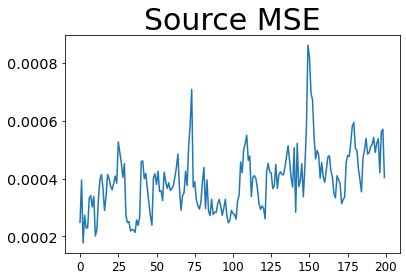

In [148]:
plt.title("Source MSE")
plt.plot(s_mse)

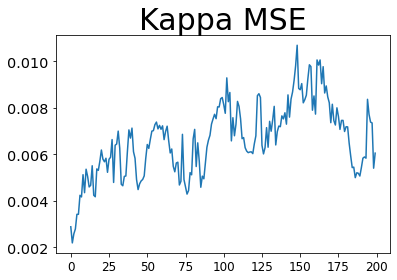

In [149]:
plt.title("Kappa MSE")
plt.plot(k_mse)

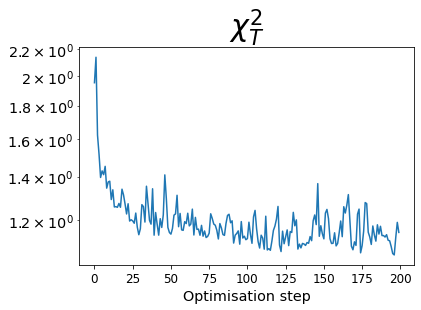

In [150]:
plt.title(r"$\chi^2_T$")
plt.plot(2*c)
plt.xlabel("Optimisation step")
plt.yscale("log")

Text(0.5, 0, 'RIM step')

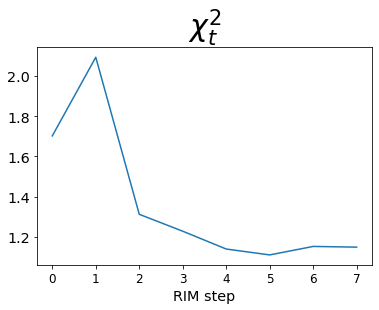

In [151]:
plt.title(r"$\chi^2_t$")
plt.plot(2 * chi_sq)
plt.xlabel("RIM step")

In [152]:
t = -1
source_p, kappa_p, chi_sq = rim.call(lens, noise_rms, psf)
# source_p, kappa_p, chi_sq = call_with_mask(rim, lens, noise_rms, psf, mask)
y_pred = phys.forward(source_p[t], 10**kappa_p[t], psf)

In [153]:
lam = phys.lagrange_multiplier(lens, y_pred).numpy().squeeze()
lam

array(1.0121129, dtype=float32)

In [154]:
lams = np.linspace(lam-0.1, lam+0.1, 100)

In [155]:
chisq_l = []
for _l in lams:
    _s = _l * source_p[-1]
    y_pred = phys.forward(_s, 10**kappa_p[-1], psf)
    _chisq = tf.reduce_mean(tf.square(lens - y_pred)/noise_rms**2).numpy()
    chisq_l.append(_chisq)

Text(0.5, 0, '$\\lambda$')

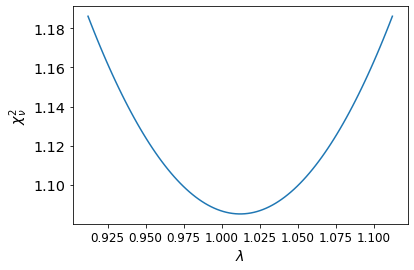

In [156]:
plt.plot(lams, chisq_l)
plt.ylabel(r"$\chi^2_\nu$")
plt.xlabel(r"$\lambda$")

In [157]:
2*chi_sq

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[1.7307866],
       [1.9361683],
       [1.2045646],
       [1.1287199],
       [1.1478349],
       [1.1068318],
       [1.0973971],
       [1.0866036]], dtype=float32)>

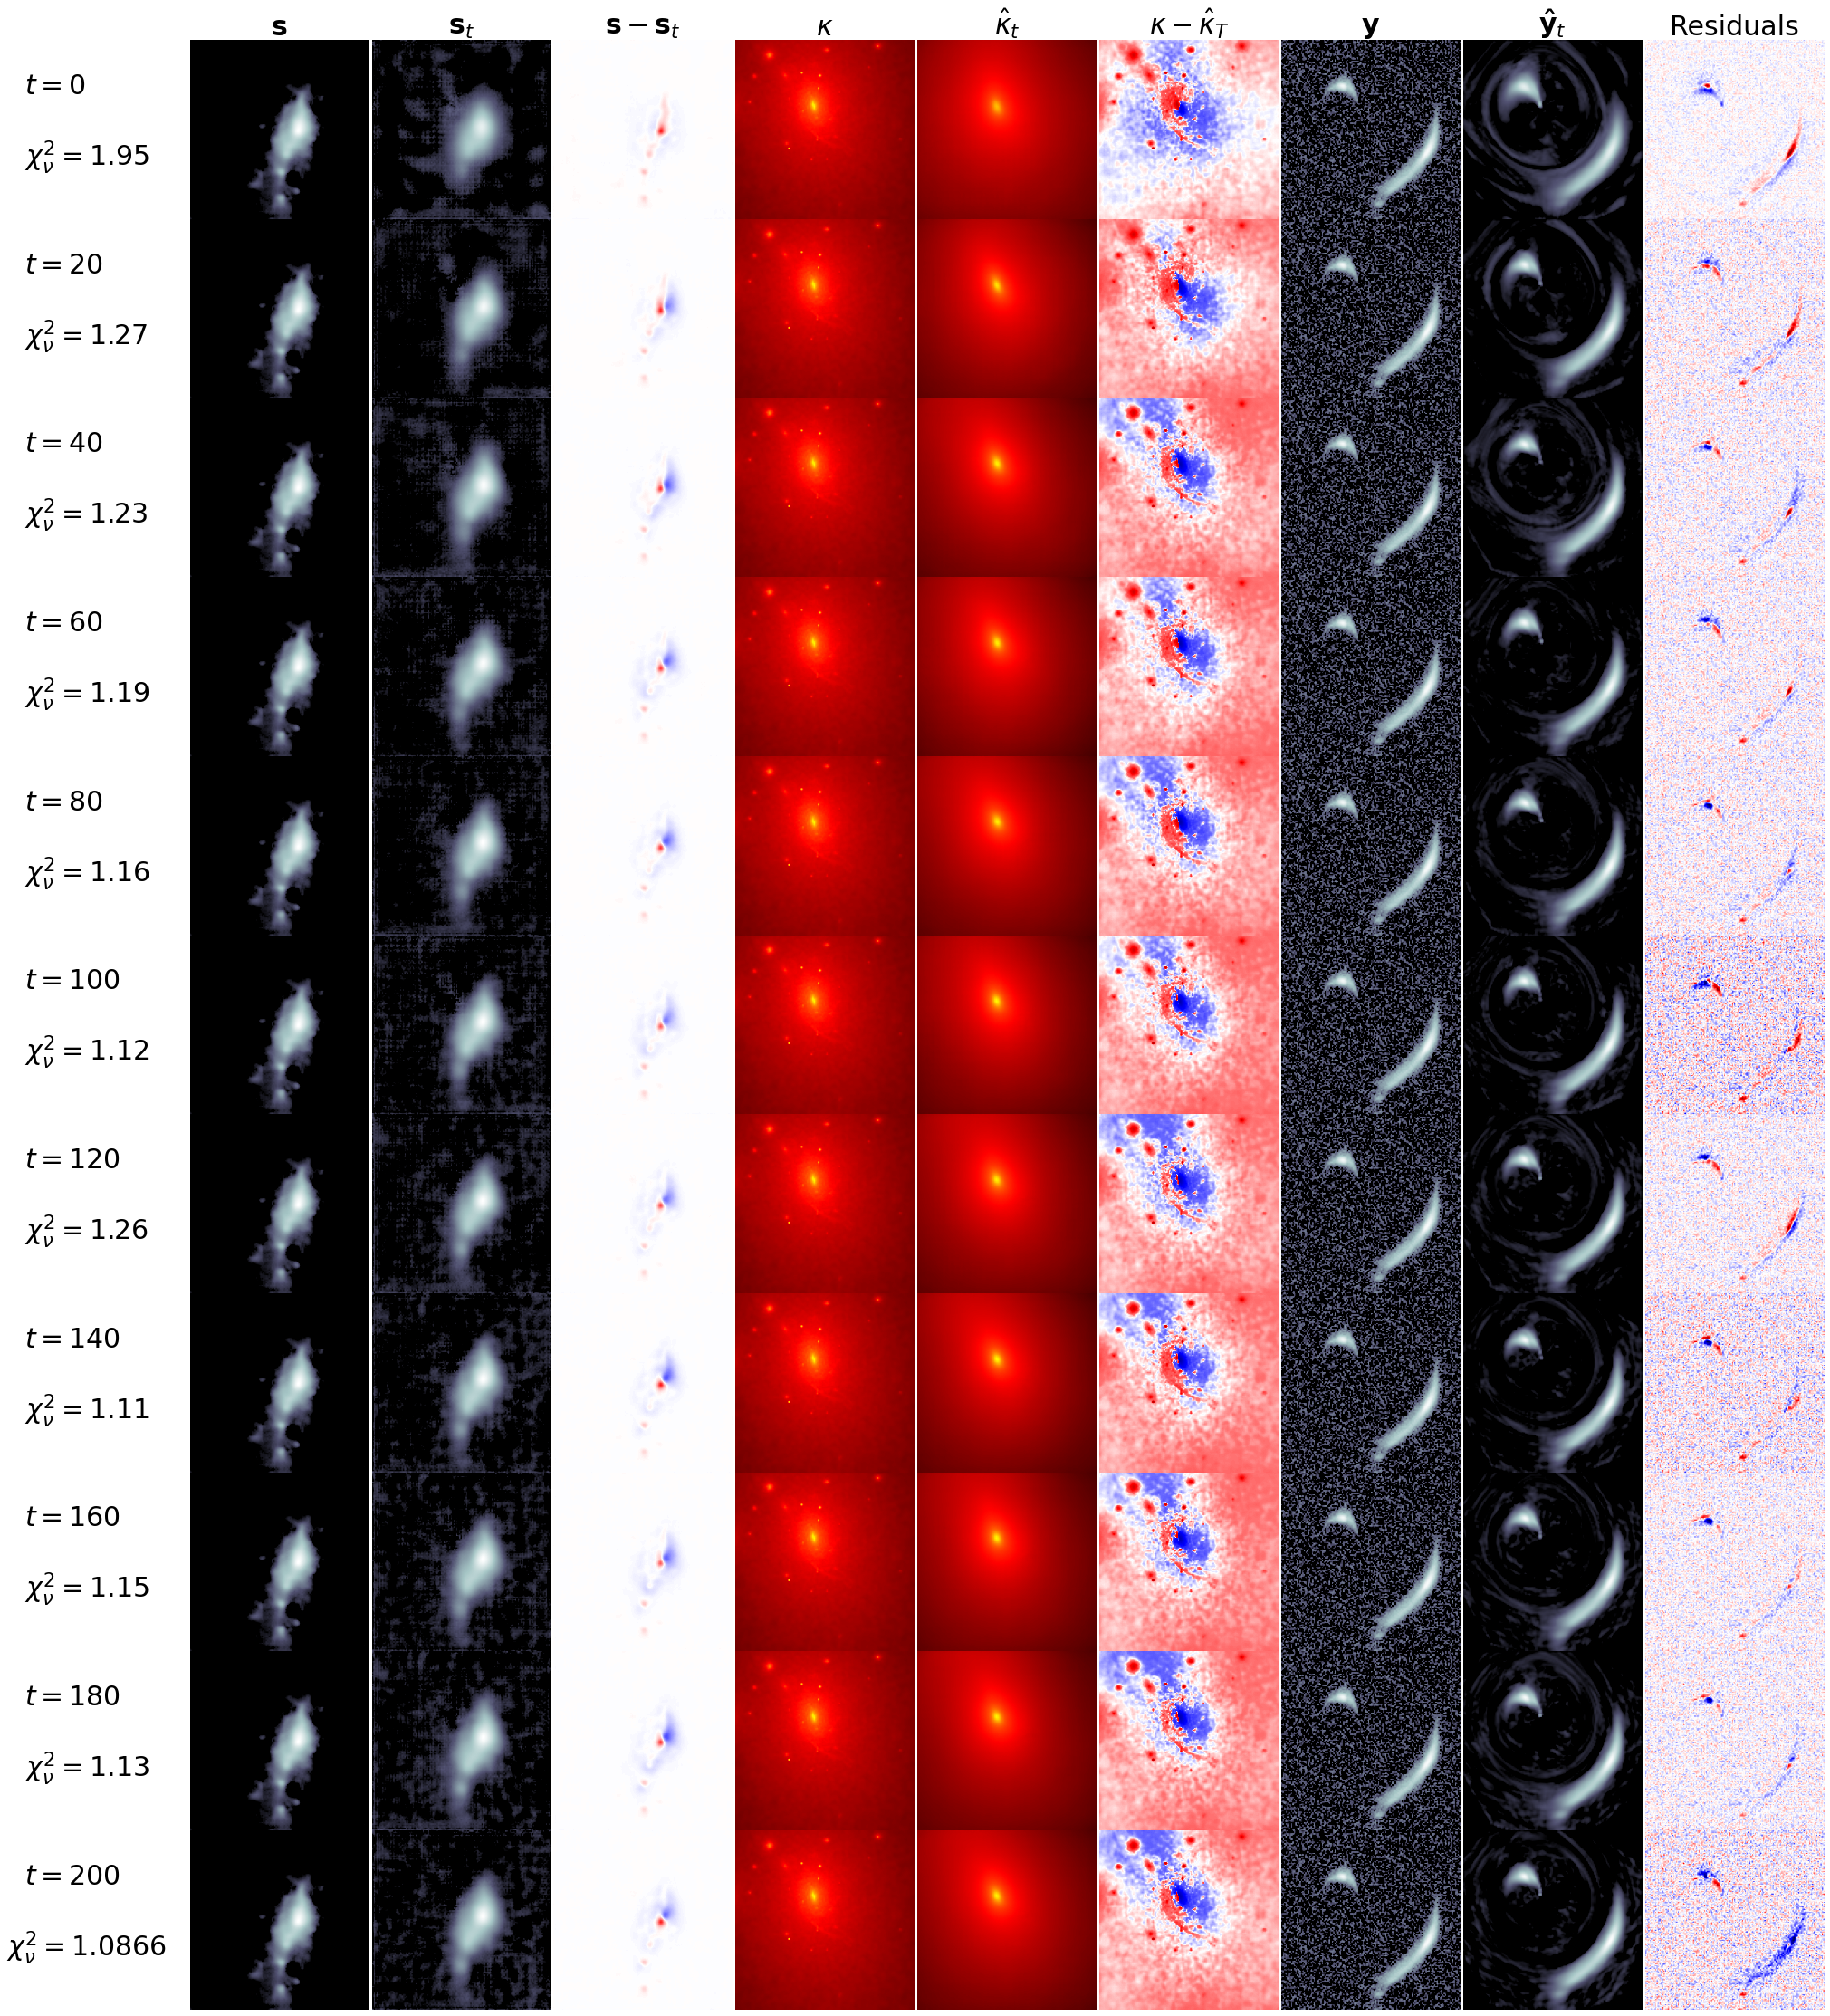

In [158]:
N = 10
fig, axs = plt.subplots(N+1, 10, figsize=(36, 4 * N))
for i in range(N):
    axs[i, 1].imshow(source[0, ..., 0], cmap="bone", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1), origin="lower")
    axs[i, 2].imshow(s[i][0, ..., 0], cmap="bone", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1), origin="lower")
    axs[i, 3].imshow(source[0, ..., 0] - s[i][0, ..., 0], cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    axs[i, 4].imshow(kappa[0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 5].imshow(k[i][0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 6].imshow(kappa[0, ..., 0] - k[i][0, ..., 0], cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100), origin="lower")
    
    axs[i, 7].imshow(lens[0, ..., 0], cmap="bone", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1), origin="lower")
    axs[i, 8].imshow(y[i][0, ..., 0], cmap="bone", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1),  origin="lower")
    axs[i, 9].imshow(lens[0, ..., 0] - y[i][0, ..., 0], cmap="seismic", norm=CenteredNorm(), origin="lower")
    
for i in range(N):
    axs[i, 0].annotate(fr"$t=${i * SAVE}", (0.1, 0.7), xycoords="axes fraction", size=30)
    axs[i, 0].annotate(fr"$\chi^2_\nu=${2*c[i * SAVE, 0]:.2f}", (0.1, 0.3), xycoords="axes fraction", size=30)
    for j in range(10):
        axs[i, j].axis("off")

axs[N, 1].imshow(source[0, ..., 0], cmap="bone", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1), origin="lower")
axs[N, 2].imshow(source_p[t][0, ..., 0], cmap="bone",norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1), origin="lower")
axs[N, 3].imshow(source[0, ..., 0] - source_p[t][0, ..., 0], cmap="seismic", vmin=-1, vmax=1, origin="lower")

axs[N, 4].imshow(kappa[0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
axs[N, 5].imshow(10**kappa_p[t][0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
axs[N, 6].imshow(kappa[0, ..., 0] - 10**kappa_p[t][0, ..., 0], cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100), origin="lower")

axs[N, 7].imshow(lens[0, ..., 0], cmap="bone", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1), origin="lower")
axs[N, 8].imshow(y_pred[0, ..., 0], cmap="bone", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1),  origin="lower")
axs[N, 9].imshow(lens[0, ..., 0] - lam * y_pred[0, ..., 0], cmap="seismic", norm=CenteredNorm(), origin="lower")

axs[N, 0].annotate(fr"$t=${N * SAVE}", (0.1, 0.7), xycoords="axes fraction", size=30)
axs[N, 0].annotate(fr"$\chi^2_\nu=${2*chi_sq[-1, 0]:.4f}", (0., 0.3), xycoords="axes fraction", size=30)
for j in range(10):
    axs[N, j].axis("off")

axs[0, 1].set_title(r"$\mathbf{s}$")
axs[0, 2].set_title(r"$\mathbf{s}_t$")
axs[0, 3].set_title("$\mathbf{s} - \mathbf{s}_t$")
axs[0, 4].set_title("$\kappa$")
axs[0, 5].set_title("$\hat{\kappa}_t$")
axs[0, 6].set_title("$\kappa - \hat{\kappa}_T$")
axs[0, 7].set_title("$\mathbf{y}$")
axs[0, 8].set_title("$\mathbf{\hat{y}}_t$")
axs[0, 9].set_title("Residuals")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(f"rim_chisq_optim2.png")

In [55]:
2*chi_sq[-1, 0] * 128**2 - 128**2

<tf.Tensor: shape=(), dtype=float32, numpy=280.4961>

# SLGD optimisation

In [156]:
lensed_image = lens

@tf.function
def train():
    step = tf.Variable(0, dtype=tf.int64)
    starter_learning_rate = 1e-5
    end_learning_rate = 1e-6
    decay_steps = 1e4
    learning_rate = tf.compat.v1.train.polynomial_decay(
        starter_learning_rate,
        step,
        decay_steps,
        end_learning_rate,
        power=1.)


    DTYPE = tf.float32
    STEPS = 10
    BURN_IN = 0
    optim = tfp.optimizer.StochasticGradientLangevinDynamics(learning_rate=learning_rate)
    optim.iterations = step
    
    source_series = tf.TensorArray(DTYPE, size=STEPS-BURN_IN)
    kappa_series = tf.TensorArray(DTYPE, size=STEPS-BURN_IN)
    chi_squared_series = tf.TensorArray(DTYPE, size=STEPS)
    source_mse = tf.TensorArray(DTYPE, size=STEPS)
    kappa_mse = tf.TensorArray(DTYPE, size=STEPS)
    lens_series = tf.TensorArray(DTYPE, size=STEPS-BURN_IN)

    for current_step in tqdm(range(STEPS)):
        with tf.GradientTape() as g:
            g.watch(unet.trainable_variables)
            s, k, chi_sq = rim.call(lens, noise_rms, psf)
            cost = tf.reduce_mean(chi_sq)
        grads = g.gradient(cost, unet.trainable_variables)
        optim.apply_gradients(zip(grads, unet.trainable_variables))

        source_o = s[-1]
        kappa_o = k[-1]
        log_likelihood = chi_sq[-1]
        y_pred = phys.forward(source_o, 10**kappa_o, psf)
        chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood)
        source_mse = source_mse.write(index=current_step, value=tf.reduce_mean((source_o - source)**2))
        kappa_mse = kappa_mse.write(index=current_step, value=tf.reduce_mean((10**kappa_o - kappa)**2))

        if current_step >= BURN_IN:
            source_series = source_series.write(index=current_step-BURN_IN, value=source_o)
            kappa_series = kappa_series.write(index=current_step-BURN_IN, value=10**kappa_o)
            lens_series = lens_series.write(index=current_step-BURN_IN, value=y_pred)


    return source_series.stack(), kappa_series.stack(), chi_squared_series.stack(), lens_series.stack(), source_mse.stack(), kappa_mse.stack()
s, k, c, y, s_mse, k_mse = train()

100%|██████████| 10/10 [01:37<00:00,  9.79s/it]


ValueError: in user code:

    <ipython-input-156-41b1acf83038>:5 train  *
        step = tf.Variable(0, dtype=tf.int64)
    /home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:262 __call__  **
        return cls._variable_v2_call(*args, **kwargs)
    /home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:244 _variable_v2_call
        return previous_getter(
    /home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:730 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


In [ ]:
plt.title(r"$\chi^2_T$")
plt.plot(c)
plt.xlabel("Optimisation step")

# Deep prior

In [4]:
# from censai.models.layers import UnetDecodingLayer, UnetEncodingLayer
# from censai.models.utils import get_activation
# from censai.definitions import DTYPE


# class UnetPrior(tf.keras.Model):
#     def __init__(
#             self,
#             filters=32,
#             filter_scaling=1,
#             kernel_size=3,
#             layers=2,                        # before bottleneck
#             block_conv_layers=2,
#             strides=2,
#             bottleneck_kernel_size=None,     # use kernel_size as default
#             bottleneck_filters=None,
#             resampling_kernel_size=None,
#             input_kernel_size=11,
#             batch_norm=False,
#             dropout_rate=None,
#             upsampling_interpolation=False,  # use strided transposed convolution if false
#             kernel_l1_amp=0.,
#             bias_l1_amp=0.,
#             kernel_l2_amp=0.,
#             bias_l2_amp=0.,
#             activation="leaky_relu",
#             alpha=0.1,                       # for leaky relu
#             use_bias=True,
#             trainable=True,
#             initializer="glorot_uniform",
#     ):
#         super(UnetPrior, self).__init__()
#         self.trainable = trainable

#         common_params = {"padding": "same", "kernel_initializer": initializer,
#                          "data_format": "channels_last", "use_bias": use_bias,
#                          "kernel_regularizer": tf.keras.regularizers.L1L2(l1=kernel_l1_amp, l2=kernel_l2_amp)}
#         if use_bias:
#             common_params.update({"bias_regularizer": tf.keras.regularizers.L1L2(l1=bias_l1_amp, l2=bias_l2_amp)})

#         kernel_size = (kernel_size,)*2
#         resampling_kernel_size = resampling_kernel_size if resampling_kernel_size is not None else kernel_size
#         bottleneck_kernel_size = bottleneck_kernel_size if bottleneck_kernel_size is not None else kernel_size
#         bottleneck_filters = bottleneck_filters if bottleneck_filters is not None else int(filter_scaling**(layers + 1) * filters)
#         activation = get_activation(activation, alpha=alpha)

#         self._num_layers = layers
#         self._strides = strides
#         self._init_filters = filters
#         self._filter_scaling = filter_scaling
#         self._bottleneck_filters = bottleneck_filters

#         self.encoding_layers = []
#         self.decoding_layers = []
#         self.gated_recurrent_blocks = []
#         for i in range(layers):
#             self.encoding_layers.append(
#                 UnetEncodingLayer(
#                     kernel_size=kernel_size,
#                     downsampling_kernel_size=resampling_kernel_size,
#                     filters=int(filter_scaling**(i) * filters),
#                     # downsampling_filters=int(filter_scaling ** (i + 1) * filters),
#                     conv_layers=block_conv_layers,
#                     activation=activation,
#                     strides=strides,
#                     batch_norm=batch_norm,
#                     dropout_rate=dropout_rate,
#                     **common_params
#                 )
#             )
#             self.decoding_layers.append(
#                 UnetDecodingLayer(
#                     kernel_size=kernel_size,
#                     upsampling_kernel_size=resampling_kernel_size,
#                     filters=int(filter_scaling**(i) * filters),
#                     conv_layers=block_conv_layers,
#                     activation=activation,
#                     bilinear=upsampling_interpolation,
#                     batch_norm=batch_norm,
#                     dropout_rate=dropout_rate,
#                     **common_params
#                 )
#             )

#         self.decoding_layers = self.decoding_layers[::-1]

#         self.bottleneck_layer1 = tf.keras.layers.Conv2D(
#             filters=bottleneck_filters,
#             kernel_size=bottleneck_kernel_size,
#             activation=activation,
#             **common_params
#         )
#         self.bottleneck_layer2 = tf.keras.layers.Conv2D(
#             filters=bottleneck_filters,
#             kernel_size=bottleneck_kernel_size,
#             activation=activation,
#             **common_params
#         )

#         self.output_layer = tf.keras.layers.Conv2D(
#             filters=2,  # source and kappa
#             kernel_size=(1, 1),
#             activation="linear",
#             **common_params
#         )

#         self.input_layer = tf.keras.layers.Conv2D(
#             filters=filters,
#             kernel_size=input_kernel_size,
#             activation=activation,
#             **common_params
#         )

# #     def __call__(self, source, kappa, source_grad, kappa_grad):
# #         return self.call(source, kappa, source_grad, kappa_grad)

# #     def call(self, source, kappa, source_grad, kappa_grad):
# #         delta_xt = tf.concat([source, source_grad, kappa, kappa_grad], axis=-1)
# #         delta_xt = self.input_layer(delta_xt)
# #         skip_connections = []
# #         new_states = []
# #         for i in range(self._num_layers):
# #             c_i, delta_xt = self.encoding_layers[i](delta_xt)
# #             skip_connections.append(c_i)
# #         skip_connections = skip_connections[::-1]
# #         delta_xt = self.bottleneck_layer1(delta_xt)
# #         delta_xt = self.bottleneck_layer2(delta_xt)
# #         for i in range(self._num_layers):
# #             delta_xt = self.decoding_layers[i](delta_xt, skip_connections[i])
# #         delta_xt = self.output_layer(delta_xt)
# #         source_delta, kappa_delta = tf.split(delta_xt, 2, axis=-1)
# #         new_source = source + source_delta
# #         new_kappa = kappa + kappa_delta
# #         return new_source, new_kappa

#     def call(self, noise):
# #         delta_xt = tf.concat([source, source_grad, kappa, kappa_grad], axis=-1)
#         delta_xt = self.input_layer(noise)
#         skip_connections = []
#         new_states = []
#         for i in range(self._num_layers):
#             c_i, delta_xt = self.encoding_layers[i](delta_xt)
#             skip_connections.append(c_i)
#         skip_connections = skip_connections[::-1]
#         delta_xt = self.bottleneck_layer1(delta_xt)
#         delta_xt = self.bottleneck_layer2(delta_xt)
#         for i in range(self._num_layers):
#             delta_xt = self.decoding_layers[i](delta_xt, skip_connections[i])
#         delta_xt = self.output_layer(delta_xt)
#         source_delta, kappa_delta = tf.split(delta_xt, 2, axis=-1)
#         return source_delta, kappa_delta


In [6]:
# prior = UnetPrior(
#     filters=4,
#     filter_scaling=2,
#     kernel_size=3,
#     layers=3,                        # before bottleneck
#     block_conv_layers=2,
#     strides=2,
#     input_kernel_size=11,
#     resampling_kernel_size=3,
#     batch_norm=True,
#     dropout_rate=None,
#     upsampling_interpolation=True,  # use strided transposed convolution if false
#     kernel_l1_amp=0.0,
#     bias_l1_amp=0.0,
#     kernel_l2_amp=0.,
#     bias_l2_amp=0.,
#     activation="leaky_relu",
#     alpha=0.1,                       # for leaky relu
#     use_bias=True,
#     trainable=True,
#     initializer="glorot_uniform",
# )

In [7]:
# a = tf.random.normal(shape=(1, 128, 128, 1))
# # prior.call(a, a, a, a); # build model
# prior.call(a);
# # prior.trainable_variables

In [8]:
# DTYPE = tf.float32
# STEPS = 1000
# SAVE = 100

# optim = tf.keras.optimizers.Adam(lr=1e-4)
# source_o = tf.Variable(tf.identity(source_pred)[None, ..., None], DTYPE)
# kappa_o = tf.Variable((tf.math.log(tf.identity(kappa_pred)[None, ..., None], DTYPE) + 1e-3)/tf.math.log(10.))
# lensed_image = lens

# # with tf.GradientTape() as g:
# #     g.watch(source_o)
# #     g.watch(kappa_o)
# #     y_pred = phys.forward(source=source_o, kappa=10**kappa_o)
# # #         lam = tf.reduce_sum(y_pred * lensed_image[None, ..., None]) / tf.reduce_sum(lensed_image**2)
# #     log_likelihood = 0.5 * tf.reduce_sum(tf.square(lensed_image - y_pred)/phys.noise_rms**2)
# # source_grad, kappa_grad = g.gradient(log_likelihood, [source_o, kappa_o])

# noise = tf.random.normal(shape=source_o.shape)

# source_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
# kappa_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
# chi_squared_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
# lens_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
# for current_step in tqdm(range(STEPS)):
#     with tf.GradientTape() as g:
#         g.watch(prior.trainable_variables)
# #         source_op, kappa_op = prior(source_o, kappa_o, tf.nn.tanh(source_grad), tf.nn.tanh(kappa_grad))
#         delta_source, delta_kappa = prior(noise)
#         y_pred = phys.forward(source=source_o - delta_source, kappa=10**(kappa_o - delta_kappa))
#         log_likelihood = 0.5 * tf.reduce_sum(tf.square(lensed_image - y_pred)/phys.noise_rms**2)
#     gradients = g.gradient(log_likelihood, prior.trainable_variables)
#     optim.apply_gradients(zip(gradients, prior.trainable_variables))
# #     with tf.GradientTape() as g:
# #         g.watch(kappa_o)
# #         y_pred = phys.forward(source=source_o, kappa=kappa_o)
# #         log_likelihood = 0.5 * tf.reduce_mean(tf.square(lensed_image - y_pred)/phys.noise_rms**2, axis=(1, 2, 3))
# #     kappa_grad = g.gradient(cost, kappa_o)
# #     optim.apply_gradients(zip([kappa_grad], [kappa_o]))
    
#     if current_step % SAVE == 0:
#         source_series = source_series.write(index=current_step//SAVE, value=source_o - delta_source)
#         kappa_series = kappa_series.write(index=current_step//SAVE, value=kappa_o - delta_kappa)
# #         source_series = source_series.write(index=current_step//SAVE, value=source_op)
# #         kappa_series = kappa_series.write(index=current_step//SAVE, value=kappa_op)
#         chi_squared_series = chi_squared_series.write(index=current_step//SAVE, value=log_likelihood)
#         lens_series = lens_series.write(index=current_step//SAVE, value=y_pred)
  
# source_series = source_series.write(index=STEPS//SAVE, value=source_o - delta_source)
# kappa_series = kappa_series.write(index=STEPS//SAVE, value=kappa_o - delta_kappa)
# # source_series = source_series.write(index=STEPS//SAVE, value=source_op)
# # kappa_series = kappa_series.write(index=STEPS//SAVE, value=kappa_op)
# chi_squared_series = chi_squared_series.write(index=STEPS//SAVE, value=log_likelihood)
# lens_series = lens_series.write(index=STEPS//SAVE, value=y_pred)
# s, k, c, y = source_series.stack(), kappa_series.stack(), chi_squared_series.stack(), lens_series.stack()

# Vanilla optimization

In [109]:
DTYPE = tf.float32
STEPS = 100
SAVE = 10

optim = tf.keras.optimizers.Adam(lr=1e-4)
source_o = tf.Variable(tf.identity(source_pred), DTYPE)
kappa_o = tf.Variable((tf.math.log(tf.identity(kappa_pred), DTYPE) + 1e-3)/tf.math.log(10.))
lensed_image = lens

# with tf.GradientTape() as g:
#     g.watch(source_o)
#     g.watch(kappa_o)
#     y_pred = phys.forward(source=source_o, kappa=10**kappa_o)
# #         lam = tf.reduce_sum(y_pred * lensed_image[None, ..., None]) / tf.reduce_sum(lensed_image**2)
#     log_likelihood = 0.5 * tf.reduce_sum(tf.square(lensed_image - y_pred)/phys.noise_rms**2)
# source_grad, kappa_grad = g.gradient(log_likelihood, [source_o, kappa_o])

noise = tf.random.normal(shape=source_o.shape)

source_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
kappa_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
chi_squared_series = tf.TensorArray(DTYPE, size=STEPS+1)
source_mse = tf.TensorArray(DTYPE, size=STEPS)
kappa_mse = tf.TensorArray(DTYPE, size=STEPS)
lens_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
for current_step in tqdm(range(STEPS)):
    with tf.GradientTape() as g:
        g.watch(kappa_o)
        g.watch(source_o)
        y_pred = phys.forward(source=source_o, kappa=10**kappa_o)
        prior = tf.square(tf.reduce_sum(y_pred) - tf.reduce_sum(lensed_image)) 
        source_prior = tf.reduce_sum(tf.nn.relu(source_o) * tf.math.log(tf.nn.relu(source_pred) / (tf.nn.relu(source_o) + 1e-6) + 1e-6))
#         kappa_prior = tf.reduce_sum(tf.maximum(10**kappa_o * tf.math.log(10**kappa_o / (10**kappa_pred + 1e-8) + 1e-8), tf.zeros_like(kappa_o)))
        log_likelihood = 0.5 * tf.reduce_sum(tf.square(lensed_image - y_pred)/phys.noise_rms**2) + prior + source_prior #+ kappa_prior 
    source_grad, kappa_grad = g.gradient(log_likelihood, [source_o, kappa_o])
    source_o = source_o - 1e-20 * source_grad
    kappa_o = kappa_o - 1e-9 * kappa_grad
#     optim.apply_gradients(zip([kappa_grad], [kappa_o]))
    chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood)
    source_mse = source_mse.write(index=current_step, value=tf.reduce_mean((source_o - source[None, ..., None])**2))
    kappa_mse = kappa_mse.write(index=current_step, value=tf.reduce_mean((10**kappa_o - kappa[None, ..., None])**2))

    if current_step % SAVE == 0:
        source_series = source_series.write(index=current_step//SAVE, value=source_o)
        kappa_series = kappa_series.write(index=current_step//SAVE, value=kappa_o)
        lens_series = lens_series.write(index=current_step//SAVE, value=y_pred)
  
source_series = source_series.write(index=STEPS//SAVE, value=source_o)
kappa_series = kappa_series.write(index=STEPS//SAVE, value=kappa_o)
chi_squared_series = chi_squared_series.write(index=STEPS, value=log_likelihood)
lens_series = lens_series.write(index=STEPS//SAVE, value=y_pred)
s, k, c, y = source_series.stack(), kappa_series.stack(), chi_squared_series.stack(), lens_series.stack()
s_mse, k_mse = source_mse.stack(), kappa_mse.stack()

100%|██████████| 100/100 [00:01<00:00, 71.55it/s]


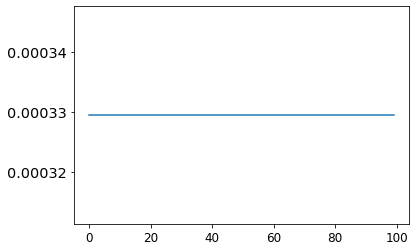

In [110]:
plt.plot(s_mse)

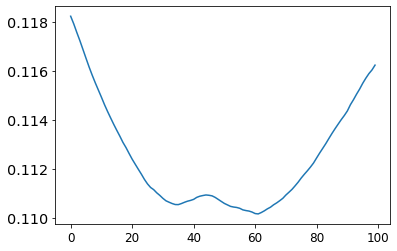

In [111]:
plt.plot(k_mse)

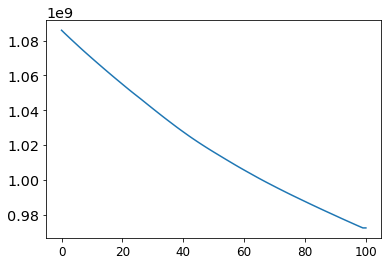

In [112]:
plt.plot(c)

<ipython-input-113-cf963ca4bc30>:18: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axs[i, 0].annotate(fr"$t=${i * SAVE}", (0.1, 0.4), textcoords="axes fraction", size=30)


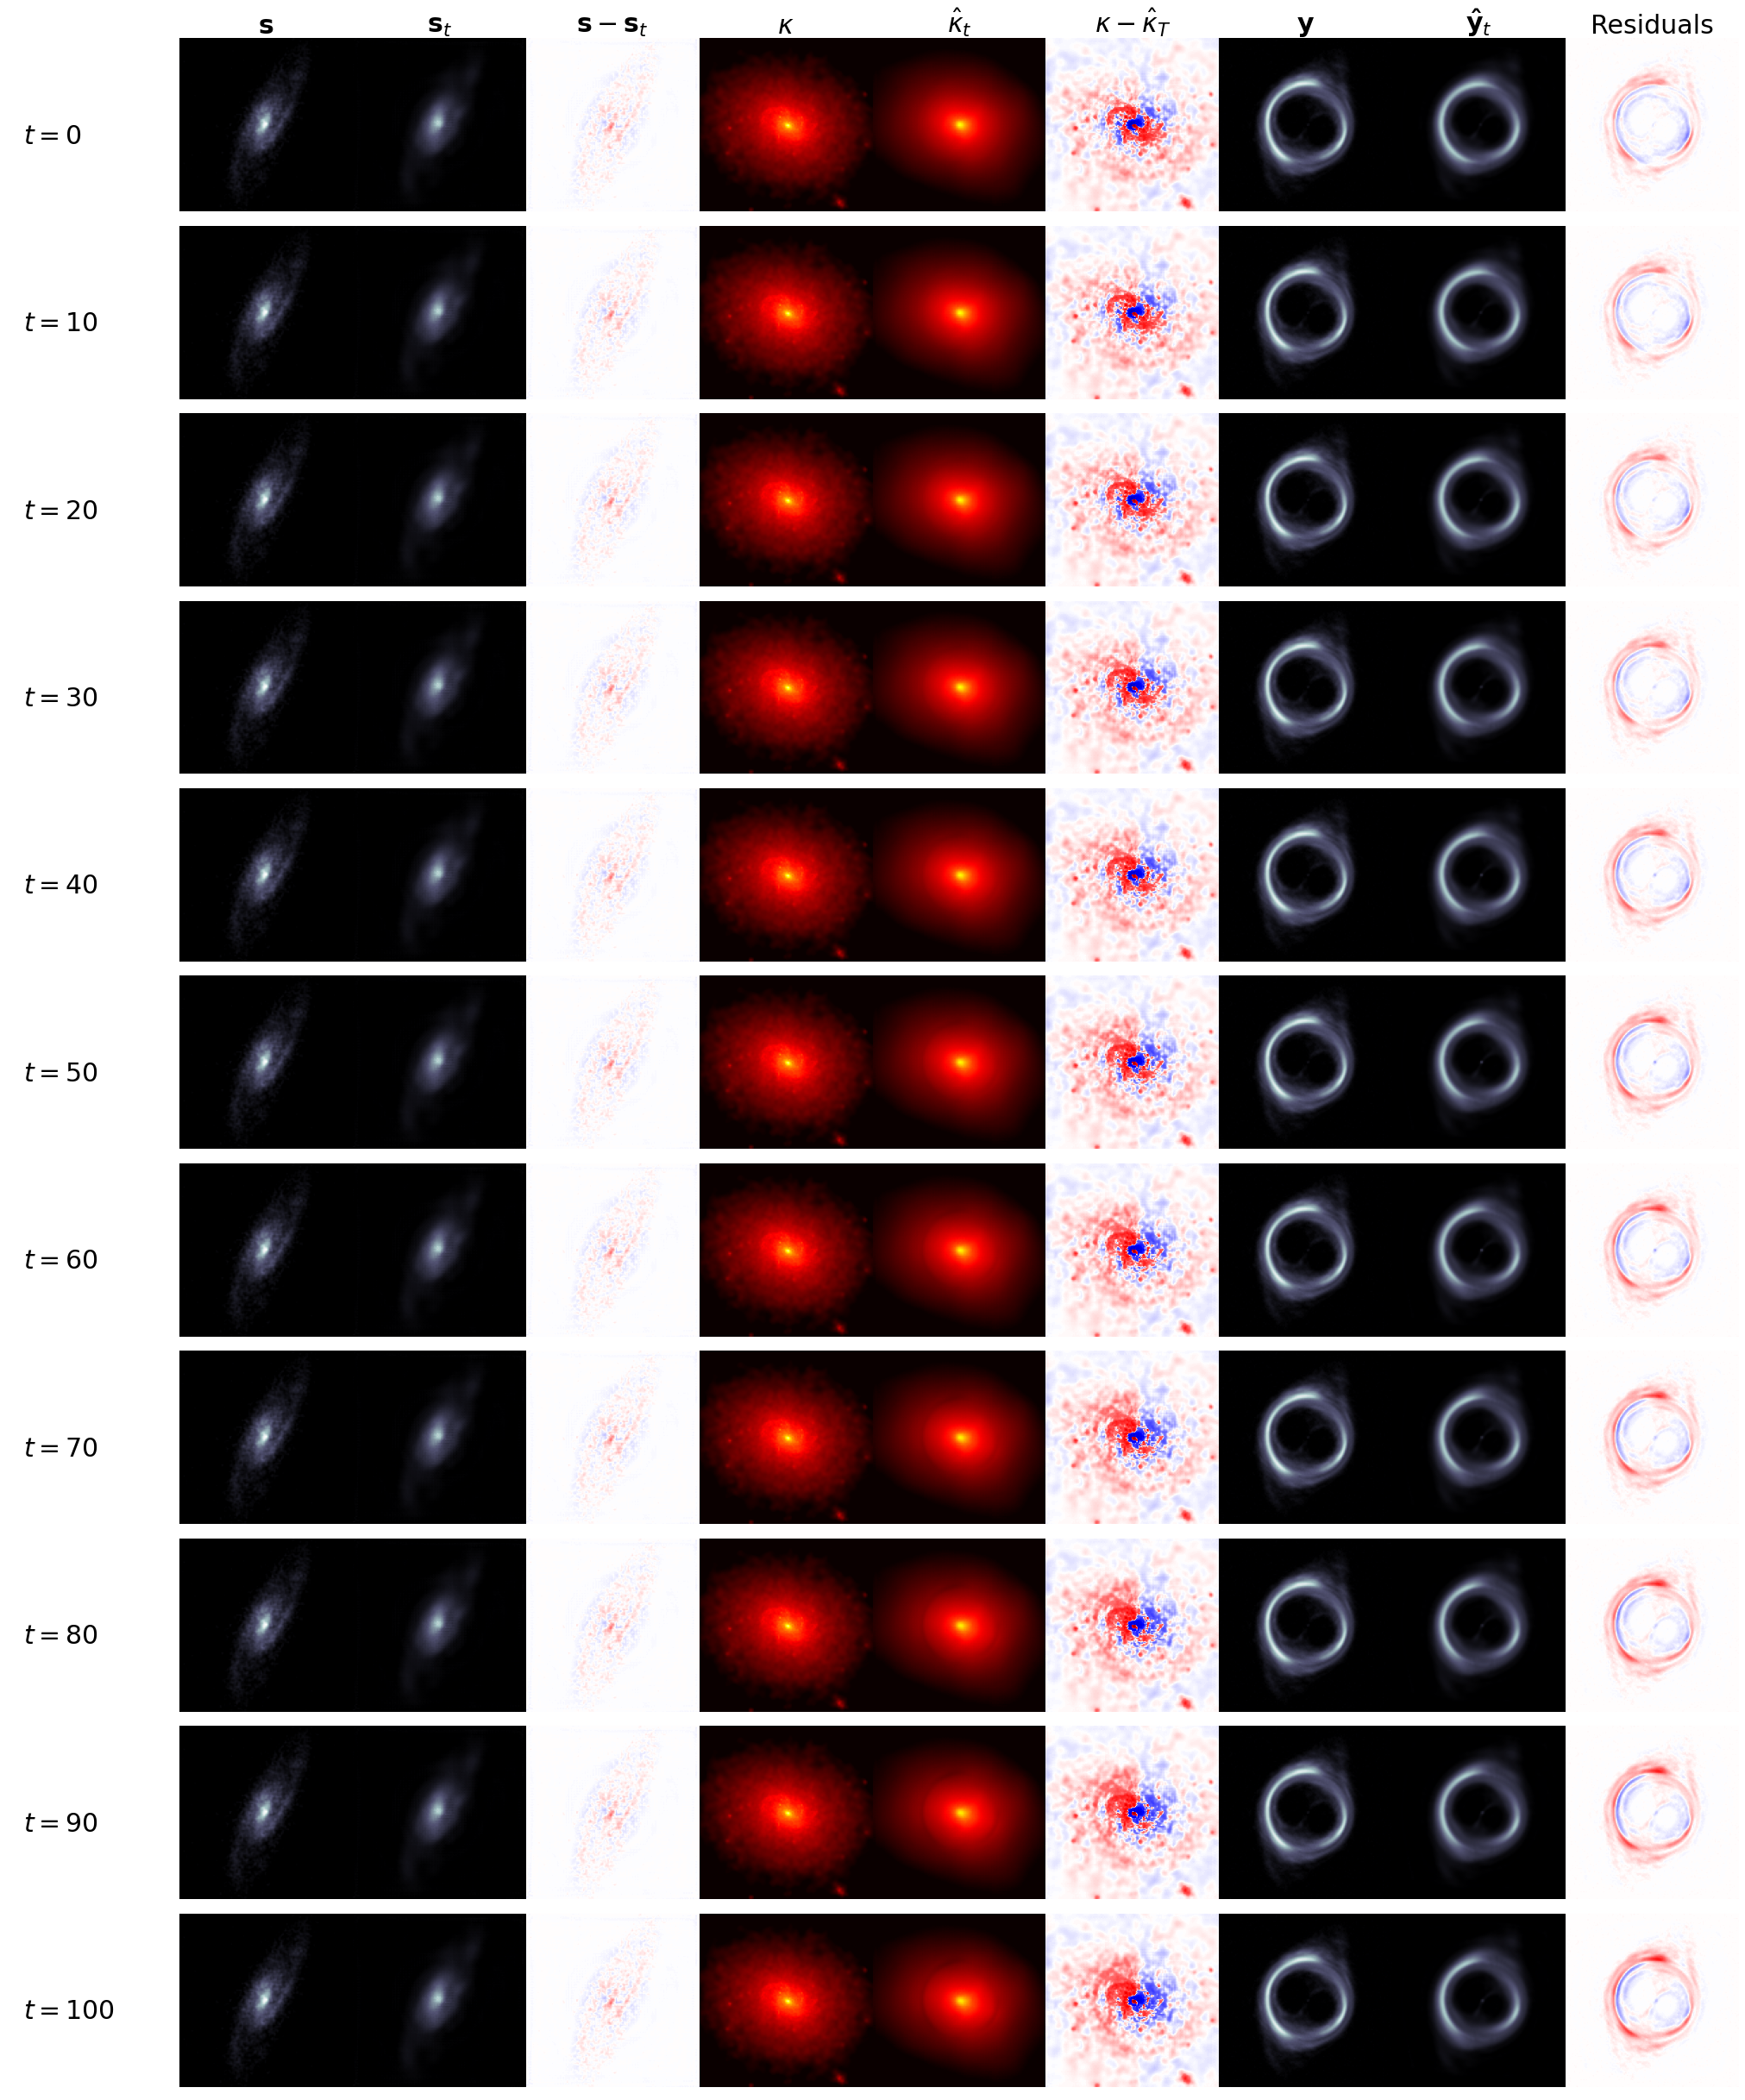

In [113]:
N = 11

fig, axs = plt.subplots(N, 10, figsize=(36, 4 * N))
for i in range(N):
    axs[i, 1].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 2].imshow(s[i][0, ..., 0], cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 3].imshow(source - s[i][0, ..., 0], cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    axs[i, 4].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 5].imshow(10**k[i][0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 6].imshow(kappa - 10**k[i][0, ..., 0], cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100), origin="lower")
    
    axs[i, 7].imshow(lens, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 8].imshow(y[i][0, ..., 0], cmap="bone", vmin=0, vmax=1,  origin="lower")
    axs[i, 9].imshow(lens - y[i][0, ..., 0], cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
for i in range(N):
    axs[i, 0].annotate(fr"$t=${i * SAVE}", (0.1, 0.4), textcoords="axes fraction", size=30)
    for j in range(10):
        axs[i, j].axis("off")

axs[0, 1].set_title(r"$\mathbf{s}$")
axs[0, 2].set_title(r"$\mathbf{s}_t$")
axs[0, 3].set_title("$\mathbf{s} - \mathbf{s}_t$")
axs[0, 4].set_title("$\kappa$")
axs[0, 5].set_title("$\hat{\kappa}_t$")
axs[0, 6].set_title("$\kappa - \hat{\kappa}_T$")
axs[0, 7].set_title("$\mathbf{y}$")
axs[0, 8].set_title("$\mathbf{\hat{y}}_t$")
axs[0, 9].set_title("Residuals")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(f"rim_pred_optim3.png")

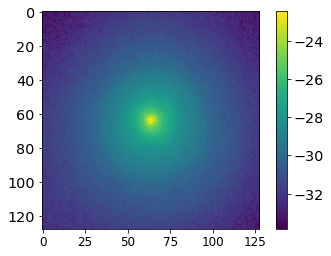

In [277]:
plt.imshow(np.log((kappa_pred - 10**k[-1][0, ..., 0]).numpy().squeeze()**2))
plt.colorbar()

In [297]:
plt.imshow((kappa - 10**k[-1])[0, ..., 0])
plt.colorbar()

TypeError: 'int' object is not subscriptable

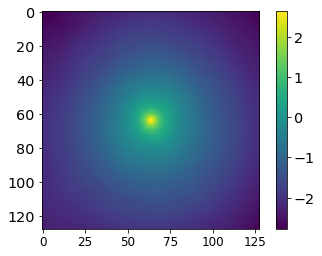

In [265]:
plt.imshow(np.log(k[-1][0, ..., 0]))
plt.colorbar()

(array([177045.,  17255.,   8882.,   6822.,   5122.,   4169.,   3524.,
          3138.,   2873.,   2735.,   2624.,   2709.,   2800.,   3127.,
          3438.,   3071.,   2884.,   2996.,   3398.,   3532.]),
 array([-8.0741628e-04,  4.8609413e-02,  9.8026238e-02,  1.4744307e-01,
         1.9685990e-01,  2.4627672e-01,  2.9569355e-01,  3.4511039e-01,
         3.9452723e-01,  4.4394404e-01,  4.9336088e-01,  5.4277772e-01,
         5.9219456e-01,  6.4161134e-01,  6.9102818e-01,  7.4044502e-01,
         7.8986186e-01,  8.3927870e-01,  8.8869548e-01,  9.3811232e-01,
         9.8752916e-01], dtype=float32),
 <BarContainer object of 20 artists>)

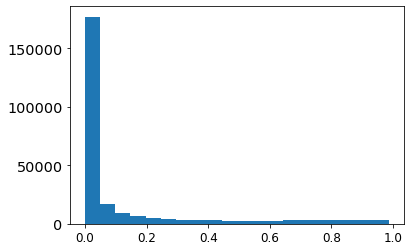

In [176]:
plt.hist(y[0].numpy().ravel(), bins=20)

(array([3.1709000e+04, 8.3759000e+04, 3.6008400e+05, 4.0760650e+07,
        6.5105559e+07, 1.0055138e+07, 6.3477470e+06, 6.9608970e+06,
        4.3382620e+06, 1.7392300e+05]),
 array([-0.8300097 , -0.65256196, -0.47511423, -0.2976665 , -0.12021875,
         0.05722898,  0.23467672,  0.41212445,  0.5895722 ,  0.7670199 ,
         0.94446766], dtype=float32),
 <BarContainer object of 10 artists>)

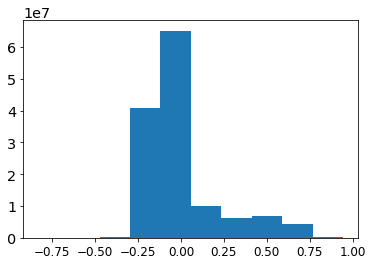

In [184]:
plt.hist((lensed_image - y[-1]).numpy().ravel())

(array([3.1709000e+04, 8.3759000e+04, 3.6008400e+05, 4.0760650e+07,
        6.5105559e+07, 1.0055138e+07, 6.3477470e+06, 6.9608970e+06,
        4.3382620e+06, 1.7392300e+05]),
 array([-0.8300097 , -0.65256196, -0.47511423, -0.2976665 , -0.12021875,
         0.05722898,  0.23467672,  0.41212445,  0.5895722 ,  0.7670199 ,
         0.94446766], dtype=float32),
 <BarContainer object of 10 artists>)

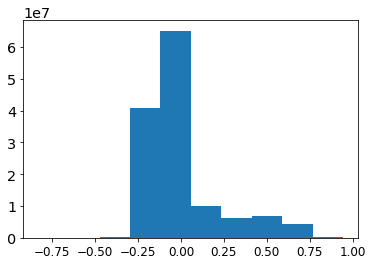

In [185]:
plt.hist((lensed_image - y_pred).numpy().ravel())

In [ ]:
f = h5py.File('yashar.h5', 'w')
g = f.create_group("rim_pred")
g.create_dataset("lens_true",        data=lens)
g.create_dataset("source_true",      data=source)
g.create_dataset("kappa_true",       data=kappa)
g.create_dataset("lens_pred",   data=lens_pred)
g.create_dataset("source_pred", data=source_pred)
g.create_dataset("kappa_pred",  data=kappa_pred)
g.create_dataset("chi_squared", data=tf.reduce_sum(tf.square(lens - lens_pred)/phys.noise_rms**2).numpy())

g = f.create_group("adam_optim")
g.create_dataset("lens",        data=y[-1].numpy().squeeze())
g.create_dataset("source",      data=s[-1].numpy().squeeze())
g.create_dataset("kappa",       data=k[-1].numpy().squeeze())
g.create_dataset("chi_squared", data=c[-1].numpy())
f.close()

In [222]:
tf.reduce_sum(tf.square(lens - lens_pred)/phys.noise_rms**2).numpy()

19257820.0

In [227]:
2*chi_squared*512**2

19257820.0

# HMC

In [13]:
tfd = tfp.distributions

# Target distribution is proportional to: `exp(-x (1 + x))`.
def unnormalized_log_prob(x):
    return -x - x**2.

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=1.,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
    return samples

samples = run_chain()
sample_mean = tf.reduce_mean(samples)
sample_stddev = tf.math.reduce_std(samples)
is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))

mean:-0.5265  stddev:0.7021  acceptance:0.6351


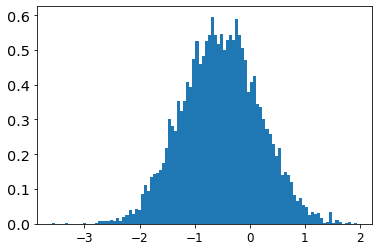

In [23]:
plt.hist(samples.numpy().squeeze(), bins=100, density=True);

# Metropolis adjusted Langevin dynamics

In [24]:
dtype = np.float32
true_mean = dtype([0, 0, 0])
true_cov = dtype([[1, 0.25, 0.25], [0.25, 1, 0.25], [0.25, 0.25, 1]])
num_results = 500
num_chains = 500

# Target distribution is defined through the Cholesky decomposition
chol = tf.linalg.cholesky(true_cov)
target = tfd.MultivariateNormalTriL(loc=true_mean, scale_tril=chol)

# Here we define the volatility function to be non-constant
def volatility_fn(x):
  # Stack the input tensors together
  return 1. / (0.5 + 0.1 * tf.math.abs(x))

# Initial state of the chain
init_state = np.ones([num_chains, 3], dtype=dtype)

# Run MALA with normal proposal for `num_results` iterations for
# `num_chains` independent chains:
states = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=target.log_prob,
        step_size=.1,
        volatility_fn=volatility_fn),
    num_burnin_steps=200,
    num_steps_between_results=1,
    trace_fn=None,
    seed=42)

sample_mean = tf.reduce_mean(states, axis=[0, 1])
x = (states - sample_mean)[..., tf.newaxis]
sample_cov = tf.reduce_mean(
    tf.matmul(x, tf.transpose(x, [0, 1, 3, 2])), [0, 1])

print('sample mean', sample_mean.numpy())
print('sample covariance matrix', sample_cov.numpy())

sample mean [ 0.00575708  0.00233531 -0.00386557]
sample covariance matrix [[1.0019025  0.24767853 0.25109583]
 [0.24767853 0.99839014 0.25406918]
 [0.25109583 0.25406918 0.99916726]]
